# **Table of contents**


1.   Import Libraries
     *   load data

2.   EDA on Tags features

  *   checking the top tags
  *   tags per question

3.   Topic assignment: Supervised Methods 

   *   Loading and generating Multi-label datasets
       *  Filtering top 100 main_tags
       *  Generating Multi-label Dataset

   *   Adapted Algorithm
       * Multi knn classifier
       * Tuning hyper-parameters for multikNN model
   *   Final model

      * Test on unseen document

## **Import Libraries**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 25 14:13:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install scikit-multilearn --quiet

     |████████████████████████████████| 89 kB 5.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import pickle
from sklearn.multiclass import OneVsRestClassifier
from nltk.tokenize import word_tokenize
from skmultilearn.adapt import MLkNN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset,ClassifierChain,BinaryRelevance
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load the data

In [4]:
data=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P7/data/10label_data.csv')
data.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)
data['bodytitles']=data['Title']+','+data['Body']
data.sample(10)

,Title,Body,Tags,bodytitles
13826,unityd ubuntu . vscode csharp extension get er...,im web developer symfony csharp microsoft tech...,csharp dotnet unityd ubuntu visualstudiocode,unityd ubuntu . vscode csharp extension get er...
12271,call implicitlydeleted default constructor uno...,"seem like try define unorderedset vector , get...",cplusplus hash set unorderedset,call implicitlydeleted default constructor uno...
7039,add fa eye icon inside input field right side ...,try add eye icon right side . origin code show...,html css,add fa eye icon inside input field right side ...
3533,computed property set call vue,accord documentation able use compute property...,javascript vuejs computedproperties,"computed property set call vue,accord document..."
1296,slant leave border multiple line text element,im look make ive try use tailwind css get hack...,css tailwindcss,"slant leave border multiple line text element,..."
2869,get error add migration use entity framework core,build console project use code first map model...,csharp entityframeworkcore,get error add migration use entity framework c...
360,telegram bot return null,try modify code webpage modify code separate c...,python pandas function telegrambot,"telegram bot return null,try modify code webpa..."
5379,happen change make use git filterbranch,"first time , try rewrite git history use . wri...",git gitfilterbranch,"happen change make use git filterbranch,first ..."
5553,get right video url instagram post use python,try build program run function input url post ...,python.x webscraping scrapy,"get right video url instagram post use python,..."
24,access fetch origin httplocalhost block cors p...,add database show error . access fetch httpxxx...,javascript reactjs,access fetch origin httplocalhost block cors p...


## **Exploratory Data Analysis of Tags feature**

### checking the top tags 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


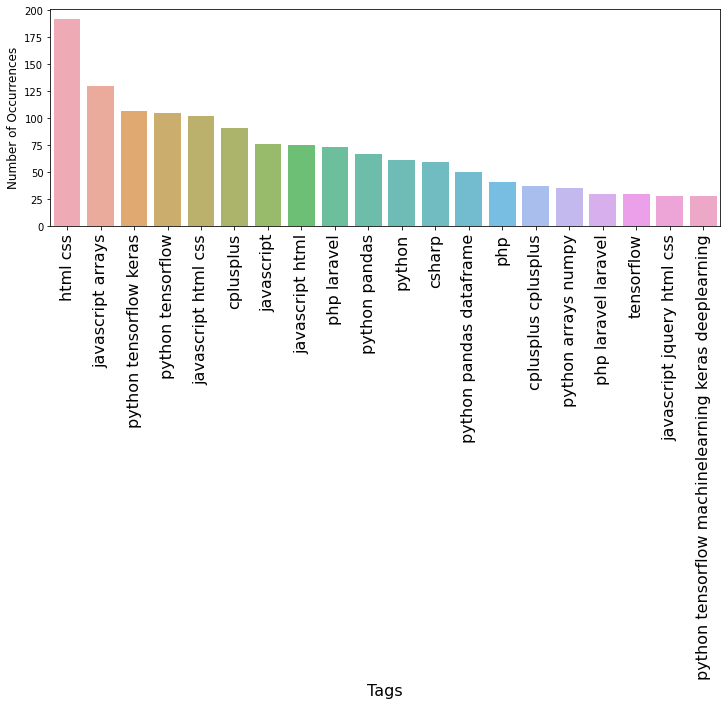

In [ ]:
count_tags=data['Tags'].value_counts().head(20)
plt.figure(figsize=(12,4))
sns.barplot(count_tags.index, count_tags.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=16)
plt.xticks(fontsize=16)
plt.xticks(rotation=90)
plt.show()

it seems like our users most recent researchs are dedicated to datascience with python and pandas.

Lets check the rest of the top tags: 

- python pandas 
- R language
- Javascripts 
- C++

### Counting the number of tags associated with each question.

In [ ]:
data['Tags_count'].value_counts()

3    4304
5    3830
4    3810
2    2621
1     657
Name: Tags_count, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


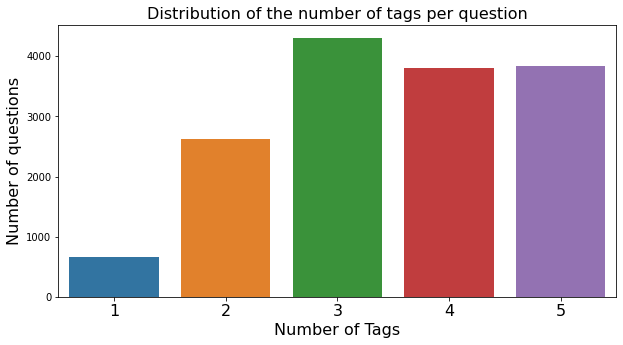

In [ ]:
# We are going to add new feature corresponding of counting tags
data['Tags_count']=data['Tags'].apply(lambda x: len(str(x).split(' ')))
tag_length=data['Tags_count'].value_counts()
plt.figure(figsize=(10,5))
#sns.countplot(df_no_dup.tag_count, palette='gist_rainbow')
sns.barplot(tag_length.index,tag_length.values)
plt.title("Distribution of the number of tags per question",fontsize=16)
plt.xlabel("Number of Tags",fontsize=16)
plt.ylabel("Number of questions",fontsize=16)
plt.xticks(fontsize=16)
plt.show()

- This shows that we have a normal distribution of our tags with the questions asked.

- most of the requests were given between 2 and 4 tags 

- we have some outliers like 10 and 11 tags which seems a bit extreme

# **Topic assignment: Supervised Methods**

## **Loading and Generating Multi-Label Datasets**


### Filtering top100  **main_tags**

In [5]:
def top_tags(df,max_tags):

  #BOW from the tags
  tag_vect=CountVectorizer()
  vectorized_tags=tag_vect.fit_transform(df['Tags'])

  #filter the top 100 tags according to occurences 
  tags_count=np.sum(vectorized_tags.toarray(),axis=0)
  sorted_tags=np.argsort(-tags_count)
  top_tags_index=sorted_tags[:max_tags]

  tags_dict={'tag':[],
             'tag_occurences':[]}

  for i in top_tags_index:
    tags_dict['tag'].append(tag_vect.get_feature_names()[i])
    tags_dict['tag_occurences'].append(tags_count[i])

  return pd.DataFrame(tags_dict)

This function help us identify the occurence of each tag along all the tags provided. 

In order to be sufficient, we are going to filter the tags and take into consideration the top 100 tags 

In [6]:
top_tag_dt=top_tags(data,10)
top_tag_dt.head(10)

,tag,tag_occurences
0,javascript,3118
1,python,2967
2,html,1958
3,csharp,1780
4,tensorflow,1669
5,arrays,1515
6,php,1513
7,cplusplus,1511
8,android,1323
9,css,1161


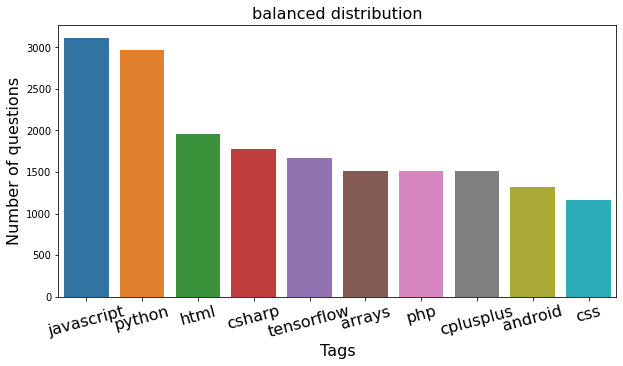

In [ ]:
plt.figure(figsize=(10,5))
#sns.countplot(df_no_dup.tag_count, palette='gist_rainbow')
sns.barplot(x='tag',y='tag_occurences', data=top_tag_dt)
plt.title("balanced distribution",fontsize=16)
plt.xlabel("Tags",fontsize=16)
plt.ylabel("Number of questions",fontsize=16)
plt.xticks(fontsize=16,rotation=15)
plt.show()

- As it was expected,we got **Python**, **Javascript**, **C++** as our top tags 

- Next we are going to keep **tags list** which contains only tags from the **top_tag** dataframe, in order to focus on the main tags 

### **Generating Multi-Label Datasets**

In order to generate the Multi-label dataset we need to: 

- keep only questions which contains the tags from the previous selection of tags 

- perform a onehot encoding to the multi-labels 

- and then merge the two dataframes

In [8]:
titles=[] # To store the filtered clean_question values
bodies=[]
mix_data=[]
y=[] # to store the corresponding tags
# Convert to list data type
lst_top_tags = top_tag_dt['tag'].values.tolist()

for i in range(len(data['Tags'])):
    temp=[]
    for tag in data['Tags'].iloc[i].split():
        if tag in lst_top_tags:
            temp.append(tag)

    if(len(temp)>0):
        titles.append(data['Title'].iloc[i])
        bodies.append(data['Body'].iloc[i])
        mix_data.append(data['bodytitles'].iloc[i])
        y.append(temp)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
label_values = mlb.fit_transform(y)

In [10]:
x_train,x_test,y_train,y_test = train_test_split(titles, label_values, test_size=0.1, random_state=42,shuffle=True)
x2_train,x2_test,y2_train,y2_test = train_test_split(bodies, label_values, test_size=0.1, random_state=42,shuffle=True)
x3_train,x3_test,y3_train,y3_test = train_test_split(mix_data, label_values, test_size=0.1, random_state=42,shuffle=True)

In [11]:
vectorizar = TfidfVectorizer(max_features=3000, max_df=0.85)
# fitting the tf-idf on the given data
X_train_tfidf=vectorizar.fit_transform(x_train)
X_test_tfidf=vectorizar.transform(x_test)

In [12]:
vectorizar = TfidfVectorizer(max_features=3000, max_df=0.85)
# fitting the tf-idf on the given data
X2_train_tfidf=vectorizar.fit_transform(x2_train)
X2_test_tfidf=vectorizar.transform(x2_test)

In [13]:
vectorizar = TfidfVectorizer(max_features=3000, max_df=0.85)
# fitting the tf-idf on the given data
X3_train_tfidf=vectorizar.fit_transform(x3_train)
X3_test_tfidf=vectorizar.transform(x3_test)

In [14]:
print('shape of X_train_tfidf: {}'.format(X_train_tfidf.shape))
print('\n')
print('shape of X_test_tfidf: {}'.format(X_test_tfidf.shape))
print('\n')
print('shape of y_train: {}'.format(y_train.shape))
print('\n')
print('shape of y_test: {}'.format(y_test.shape))

shape of X_train_tfidf: (11290, 3000)


shape of X_test_tfidf: (1255, 3000)


shape of y_train: (11290, 10)


shape of y_test: (1255, 10)


## **Adapted Algorithm**

- Adapted algorithm: As the name suggests, adapting the algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems.

For example, multi-label version of kNN is represented by MLkNN. So, let us quickly implement this on our randomly generated data set.

### Multi Knn classifier

In [21]:
mlknn_classifier = MLkNN(k=20)
mlknn_classifier.fit(X3_train_tfidf, y3_train)

MLkNN(ignore_first_neighbours=0, k=20, s=1.0)

In [ ]:
mlknn_classifier.knn_

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [22]:
predicted = mlknn_classifier.predict(X3_test_tfidf)
  
print(accuracy_score(y3_test, predicted))
print(hamming_loss(y3_test, predicted))

0.500398406374502
0.07434262948207171


### Tuning hyper parameter for mult-knn model

- In order to get the optimal number of the k neighbors for our model. We are running a hyper-parameter tuning. 

- As a metric of evaluation we did choose the accuracy score and the hamming_loss with more importance given to the second one. 

- So to obtain the best k neighbor we are choosing the value that gave the best accuracy score and the lowest hamming_loss

In [ ]:
#range of k_neighbour
ham_loss=[]
acc_score=[]
for kn in range(10,31,2):
  ml=MLkNN(k=kn)
  ml.fit(X_train_tfidf, y_train)
  pred_ml=ml.predict(X_test_tfidf)
  ham_loss.append(hamming_loss(y_test, pred_ml))
  acc_score.append(accuracy_score(y_test, pred_ml))


In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

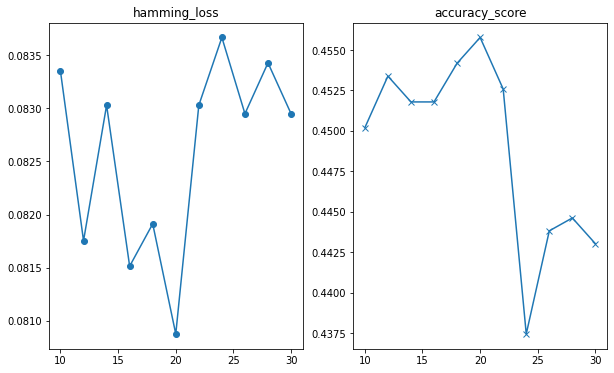

In [ ]:
fig=plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(range(10,31,2),ham_loss,marker='o')
ax1.title.set_text('hamming_loss')
ax2.plot(range(10,31,2),acc_score,marker='x')
ax2.title.set_text('accuracy_score')
plt.show()

In [ ]:
mlknn_classifier = MLkNN(k=20)
mlknn_classifier.fit(X_train_tfidf, y_train)

MLkNN(ignore_first_neighbours=0, k=20, s=1.0)

In [ ]:
pred_best= model.predict(X_test_tfidf)
  
print(accuracy_score(y_test, pred_best))
print(hamming_loss(y_test, pred_best))

0.45577689243027886
0.08087649402390439


In [ ]:
filename = '/content/drive/MyDrive/Formation_Machine_Learning/P7/Baseline/finalized_model.sav'
pickle.dump(mlknn_classifier, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/Formation_Machine_Learning/P7/Baseline/finalized_vect.sav'
pickle.dump(vectorizar, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/Formation_Machine_Learning/P7/Baseline/mlb.sav'
pickle.dump(mlb, open(filename, 'wb'))

### Test on unseen document

In [ ]:
test_doc='returning a value from within a nested javascript function duplicate'

In [ ]:
model=pickle.load(open('/content/drive/MyDrive/Formation_Machine_Learning/P7/Baseline/finalized_model.sav', 'rb'))

In [ ]:
vectorizar=pickle.load(open('/content/drive/MyDrive/Formation_Machine_Learning/P7/Baseline/finalized_model.sav', 'rb'))

In [ ]:
def get_prediction(model,text):

  text_vect=vectorizar.transform([text])
  pred=model.predict(text_vect).toarray()
  pred_indexs=np.argsort(-pred)[:,:np.sum(pred)][0]
  tags_list=list(mlb.classes_[pred_indexs])

  return tags_list

In [ ]:
model=mlknn_classifier

In [ ]:
text_vect=vectorizar.transform([test_doc])
pred=model.predict(text_vect).toarray()


In [ ]:
mlb.classes_

array(['android', 'arrays', 'cplusplus', 'csharp', 'css', 'html',
       'javascript', 'php', 'python', 'tensorflow'], dtype=object)

In [ ]:
pred_indexs=np.argsort(-pred)[:,:np.sum(pred)][0]

In [ ]:
import ast

In [ ]:
list(mlb.classes_[pred_indexs])

['arrays', 'javascript']

In [ ]:
get_prediction(mlknn_classifier,test_doc)

NameError: ignored

In [ ]:
test_doc2='how would firebase be connected to a flask app'

In [ ]:
get_prediction(mlknn_classifier,test_doc2)

['firebase', 'flutter']

In [ ]:
test_doc3='how local transitivity and barrat transitivity are calculated for directed graph in igraph rlang'

In [ ]:
get_prediction(mlknn_classifier,test_doc3)

[]

In [ ]:
test_doc4='faster way to query pandas dataframe for a value based on values in other column'

In [ ]:
get_prediction(mlknn_classifier,test_doc4)

['python', 'dataframe', 'pandas']

In [ ]:
test_doc5='how to create json file based on pandas dataframe python'
get_prediction(mlknn_classifier,test_doc5)

['python', 'json', 'pandas']

In [ ]:
test_doc6='returning a value from within a nested javascript function duplicate'
get_prediction(mlknn_classifier,test_doc6)

['arrays', 'javascript']

In [ ]:
test_doc7=  
get_prediction(mlknn_classifier,test_doc7)

['django']